# Event Cropping

This is where I select the event that I care about and make it look pretty for processing

In [1]:
# Data
import numpy as np
import netCDF4 as nf
import pandas as pd
import xarray as xr
import datetime
# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
# Image Rendering
import imageio
from IPython.display import Image

## Functions to utilize

In [2]:
def plot_background_no_lims(ax):
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

def plot_subset_background(ax, lonmin, lonmax, latmin, latmax):
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

def find_storm_domain(dataset):
    bounds = [None] * 4
    bounds[0] = dataset['longitude'].min()
    bounds[1] = dataset['longitude'].max()
    bounds[2] = dataset['latitude'].min()
    bounds[3] = dataset['latitude'].max()
    return bounds

def write_settings_to_file(file_path, year, start_day, HHMMSS_start, end_day, HHMMSS_end, domain):
    settings = {
        'year': str(year),
        'start_day': str(start_day),
        'HHMMSS_start': str(HHMMSS_start).zfill(6),  # Ensure six digits
        'end_day': str(end_day),
        'HHMMSS_end': str(HHMMSS_end).zfill(6),  # Ensure six digits
        'domain': domain  # List remains as it is
    }
    
    with open(file_path, 'w') as file:
        for key, value in settings.items():
            if isinstance(value, list):
                value_str = '[' + ', '.join(map(str, value)) + ']'  # Convert list to string
            else:
                value_str = str(value)
            file.write(f"{key}={value_str}\n")


## Constants 

And stuff

In [95]:
# Plotting colorbar nomalization
pmin = 940
pmax = 1040

crs_us = ccrs.LambertConformal(central_longitude=260.0)
crs_global_atlantic = ccrs.PlateCarree(central_longitude=0.0)
crs_pnw = ccrs.LambertConformal(central_longitude=240.0)


In [96]:
# Zero-ing in on the event itself
year = '2021'
start_day = '1023'
HHMMSS_start = "000000"
end_day = '1026'
HHMMSS_end = "000000"
# Construct the timeframe
timeframe = (
    pd.to_datetime("%s-%s-%s %s:%s:%s" % (year, start_day[0:2], start_day[2:], HHMMSS_start[0:2], HHMMSS_start[2:4], HHMMSS_start[4:])),
    pd.to_datetime("%s-%s-%s %s:%s:%s" % (year, end_day[0:2], end_day[2:], HHMMSS_end[0:2], HHMMSS_end[2:4], HHMMSS_end[4:]))
)

time_slice = (
    pd.to_datetime("%s-%s-%s %s:%s:%s" % (year, str(int(start_day)-1)[:len(str(int(start_day)))-2].zfill(2), str(int(start_day)-1)[len(str(int(start_day)))-2:].zfill(2), HHMMSS_start[0:2], HHMMSS_start[2:4], HHMMSS_start[4:])),
    pd.to_datetime("%s-%s-%s %s:%s:%s" % (year, str(int(end_day)-1)[:len(str(int(start_day)))-2].zfill(2), str(int(end_day)-1)[len(str(int(end_day)))-2:].zfill(2), HHMMSS_end[0:2], HHMMSS_end[2:4], HHMMSS_end[4:]))
)

print("Timeframe: " , timeframe)

Timeframe:  (Timestamp('2021-10-23 00:00:00'), Timestamp('2021-10-26 00:00:00'))


## File IO

In [97]:
era = xr.open_dataset('%s/sfc_mslp_6hr_%s.nc'%('data/ERA5',year))
era = era.sel(time=slice(timeframe[0],timeframe[1]))
era['msl'] /= 100

time_arr = era['time'].to_numpy()
era

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 13)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2021-10-23 ... 2021-10-26
Data variables:
    msl        (time, latitude, longitude) float32 1.027e+03 ... 1.018e+03
Attributes:
    Conventions:  CF-1.6
    history:      2024-04-17 17:35:31 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

## Plots

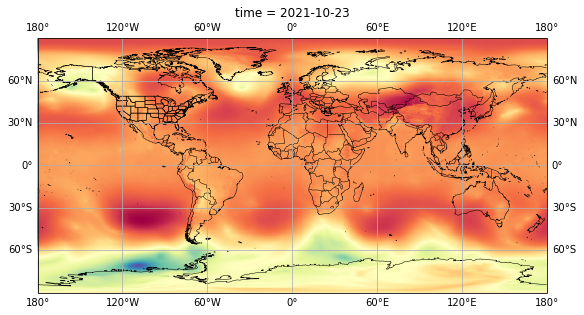

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (8,7), constrained_layout=True,
                            subplot_kw={'projection': crs_global_atlantic})
domain = find_storm_domain(era)
#plot_subset_background(axes[0], domain[0], domain[1], domain[2], domain[3])
#plot_subset_background(axes[1], domain[0], domain[1], domain[2], domain[3])
plot_background_no_lims(axes)

cf1 = era['msl'].isel(time=0).plot(ax=axes, x='longitude', y='latitude',
                    cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder = 0, add_colorbar = False)

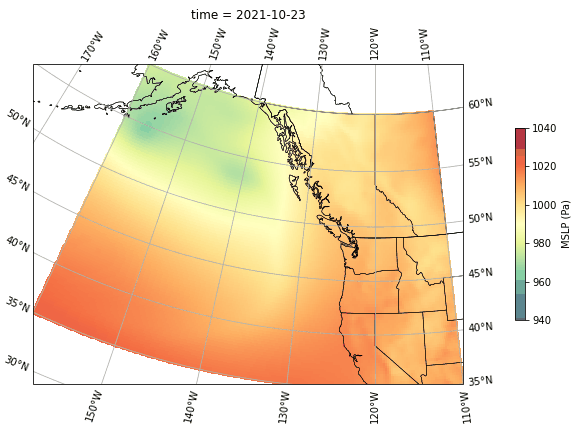

In [100]:
domain=[200,250,35,60]
#domain=[240, 300, 30, 60]

cyclone_progress = []
frames = []
for time in time_arr:
    msl_subset = era['msl'].sel(time=time).sel(longitude=slice(domain[0], domain[1]), latitude=slice(domain[3], domain[2]))
    #print(msl_subset)

    # Find the minimum pressure value and its indices within the subset
    minp = np.nanmin(msl_subset)
    min_indices = np.unravel_index(np.nanargmin(msl_subset), msl_subset.shape)
    
    # Calculate the latitude and longitude values based on the domain
    lon_values = msl_subset['longitude'].values[min_indices[1]]
    lat_values = msl_subset['latitude'].values[min_indices[0]]
    
    # Create a dictionary to store the cyclone information
    cyclone_dict = {'lon': lon_values, 'lat': lat_values, 'msl': minp}
    
    # Append the cyclone dictionary to the cyclone progress list
    cyclone_progress.append(cyclone_dict)

    # Now working on making the plots
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6),constrained_layout=True,
                            subplot_kw={'projection': crs_pnw}, facecolor='w')

    plot_subset_background(ax,domain[0],domain[1],domain[2],domain[3])
    
    cf1 = era['msl'].sel(time=time).sel(longitude=slice(domain[0],domain[1]),latitude=slice(domain[3],domain[2])).plot(ax=ax, x='longitude', y='latitude',
                    cmap='Spectral_r', transform=ccrs.PlateCarree(), zorder = 0, add_colorbar = False, vmin=pmin, vmax=pmax)
    fig.colorbar(cf1, ax = ax, shrink = 0.5).set_label(label = 'MSLP (Pa)')
    fig.savefig('gifs/frames/%s_%s_ERA5.png'%(year, start_day))
    picture = imageio.imread('gifs/frames/%s_%s_ERA5.png'%(year, start_day))
    frames.append(picture)
    plt.close()
#print(len(frames))
imageio.mimsave('gifs/%s_%s_ERA5.gif'%(year, start_day), frames, duration = 0.5)
Image('gifs/%s_%s_ERA5.gif'%(year, start_day))

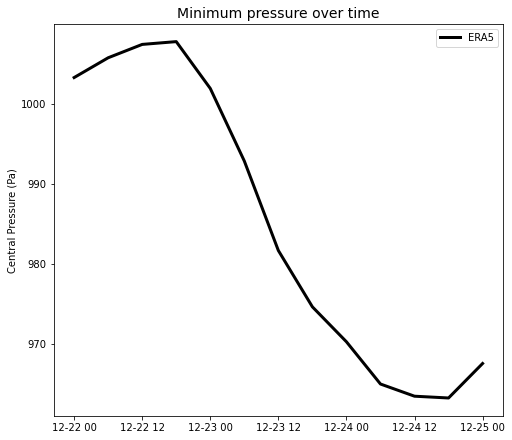

In [92]:
fig, ax = plt.subplots(1,1,figsize = (7,6), constrained_layout=True, facecolor = 'w')

era_mins = [times_e['msl'] for times_e in cyclone_progress]

ax.plot(time_arr, era_mins, label = 'ERA5', color = 'black', linewidth=3)

ax.set_title("Minimum pressure over time", fontsize = 14)
ax.set_ylabel("Central Pressure (Pa)")
ax.legend()

In [93]:
# We will need to adjust this rate to adjust for latitude
def bomb_cyclone_check(cyclone_list):
    bomb_cyclone_in = []
    rate_list = []
    for t, c_dict in enumerate(cyclone_list):
        count = 1
        while(t-count >= 0 and count <= 4):
            #print("t = %s\t t-%s = %s"%(str(t),str(count), str(t-count)))

            # Represents the percentage of the bomb-cyclone intensification rate when using 1mbhr^-1
            int_r8 = ((cyclone_list[t-count]['msl'] - c_dict['msl'])/(6*count))
            rate_list.append(int_r8)
            #print(int_r8)
            if int_r8 > 1: 
                print("Bomb cyclone at: " +str(t))
                bomb_dict = {'t_curr' : t,
                             't_begin' : t-count,
                             'msl_curr' : c_dict['msl'],
                             'msl_begin' : cyclone_list[t]['msl'],
                             'rate' : int_r8}
                bomb_cyclone_in.append(bomb_dict)
            count += 1
    print("Maximum intensification rate: " , np.nanmax(rate_list))

    return bomb_cyclone_in

bomb_list = bomb_cyclone_check(cyclone_progress)
for i,b in enumerate(bomb_list):
    rate_list.append(b)
    print(b , '\n')

Bomb cyclone at: 5
Bomb cyclone at: 5
Bomb cyclone at: 6
Bomb cyclone at: 6
Bomb cyclone at: 6
Bomb cyclone at: 6
Bomb cyclone at: 7
Bomb cyclone at: 7
Bomb cyclone at: 7
Bomb cyclone at: 7
Bomb cyclone at: 8
Bomb cyclone at: 8
Bomb cyclone at: 9
Maximum intensification rate:  1.8640645345052083
{'t_curr': 5, 't_begin': 4, 'msl_curr': 992.8468, 'msl_begin': 992.8468, 'rate': 1.512054443359375} 

{'t_curr': 5, 't_begin': 3, 'msl_curr': 992.8468, 'msl_begin': 992.8468, 'rate': 1.24383544921875} 

{'t_curr': 6, 't_begin': 5, 'msl_curr': 981.6624, 'msl_begin': 981.6624, 'rate': 1.8640645345052083} 

{'t_curr': 6, 't_begin': 4, 'msl_curr': 981.6624, 'msl_begin': 981.6624, 'rate': 1.6880594889322917} 

{'t_curr': 6, 't_begin': 3, 'msl_curr': 981.6624, 'msl_begin': 981.6624, 'rate': 1.4505784776475694} 

{'t_curr': 6, 't_begin': 2, 'msl_curr': 981.6624, 'msl_begin': 981.6624, 'rate': 1.073407491048177} 

{'t_curr': 7, 't_begin': 6, 'msl_curr': 974.62134, 'msl_begin': 974.62134, 'rate': 1.1735

Text(0.5, 1.0, 'Cyclone central low pressure over time classified by Intensification rate')

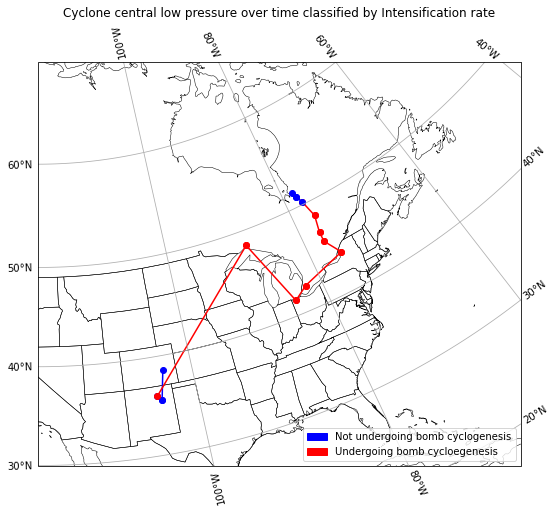

In [94]:
# Create the plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 7), constrained_layout=True, subplot_kw={'projection': crs_pnw}, facecolor='w')
plot_subset_background(ax, domain[0], domain[1], domain[2], domain[3])

lons = []
lats = []
msls = []

# Initialize color list
colors = []

for cyc in cyclone_progress:
    lons.append(cyc['lon'])
    lats.append(cyc['lat'])
    msls.append(str(cyc['msl']))
    colors.append('blue')  # Default color is blue

# Identify the time intervals when the cyclone is undergoing bomb cyclone intensification
for bomb_cyclone in bomb_list:
    start_t = bomb_cyclone['t_begin']
    end_t = bomb_cyclone['t_curr']
    # Set color to red for the time interval when the cyclone is undergoing bomb cyclone intensification
    colors[start_t:end_t+1] = ['red'] * (end_t - start_t + 1)

for i in range(len(lons) - 1):
    ax.plot([lons[i], lons[i+1]], [lats[i], lats[i+1]], color=colors[i], marker='o', transform=ccrs.PlateCarree())

blue_patch = mpatches.Patch(color='blue', label='Not undergoing bomb cyclogenesis')
red_patch = mpatches.Patch(color='red', label='Undergoing bomb cycloegenesis')
ax.legend(handles=[blue_patch, red_patch], loc='lower right')

ax.set_title("Cyclone central low pressure over time classified by Intensification rate")

In [ ]:
# Specify the file path where you want to save the settings
file_path = "settings/%s_%s_settings.txt"%(start_day,year)

# Call the function to write the settings to the file
write_settings_to_file(file_path, int(year), int(start_day), HHMMSS_start, int(end_day), HHMMSS_end, domain)